# Introduction

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/Colab Notebooks/MNIST-classification'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Importing Libraries and Data

In [ ]:
# generel utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from utils import show_example, plot_training_history
from IPython.display import clear_output

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# keras tuner
!pip install keras-tuner
clear_output()
from keras_tuner import HyperModel, RandomSearch

# function to read matlab data file
from scipy.io import loadmat

In [ ]:
X = loadmat(f'{root}/data/mnist_training_data.mat')['training_data']
y = loadmat(f'{root}/data/mnist_training_label.mat')['training_label']

X_test = loadmat(f'{root}/data/mnist_test_data.mat')['test_data']
y_test = loadmat(f'{root}/data/mnist_test_label.mat')['test_label']

train_size, n_features = X.shape
test_size, _ = X_test.shape
seed = 0

shuffled_indices = np.random.permutation(train_size)
X = X[shuffled_indices]
y = y[shuffled_indices]

print(f"No. of features:\t\t{n_features}")
print(f"No. of training examples:\t{train_size}")
print(f"No. of test examples:\t\t{test_size}")

No. of features:		784
No. of training examples:	50000
No. of test examples:		10000


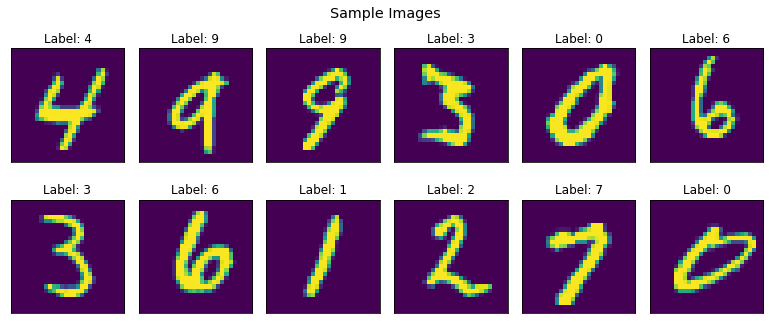

In [ ]:
show_example(X, y)

# Configuring GPU

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"No. of GPUs available: {len(physical_devices)}")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

No. of GPUs available: 1


# Selecting Model Architecture by Cross-validation

We select number of hidden layers and number of units in each layers by cross validation. We chose to vary number of hidden layers from 1 to 10 and for each number of layers we search for the optimum number of hidden units in each layer. The number of units in each hidden layer are chosen from the set $\{16i : i=1(1)32\}$. We take the model resulting the maximum validation accuracy for each number of layers.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(X, y)][0]

X_train, X_val = X[train_idx, :], X[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

scaler = MinMaxScaler()
Z_train = scaler.fit_transform(X_train)
Z_val  = scaler.transform(X_val)
Z_test = scaler.transform(X_test)

import pickle
with open(f'{root}/models/scaler_wo_pca.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Building Hypermodel and Searching for the Best Model 

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, classes, layers):
        self.classes = classes
        self.layers = layers

    def build(self, hp):
        # Build Model
        model = keras.Sequential()
        for i in range(self.layers):
            model.add(layers.Dense(
                units=hp.Choice(
                    f"layer_{i+1:02}", 
                    values=list(range(16, 513, 16))
                ),
                kernel_initializer='he_uniform',
                activation='relu'
            ))
        model.add(layers.Dense(self.classes, activation='softmax'))

        # Compile Model
        model.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

In [ ]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    tuner.search(
        Z_train, y_train, validation_data=(Z_val, y_val),
        epochs=500, batch_size=5000, verbose=1 , callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.9688000082969666

Best val_accuracy So Far: 0.9778000116348267
Total elapsed time: 00h 03m 26s
INFO:tensorflow:Oracle triggered exit


## Creating Models from the Best Model Architectures

In [ ]:
def create_model(input_size, num_units):
    model = Sequential()
    model.add(layers.InputLayer(input_size))
    for units in num_units.values():
        model.add(layers.Dense(
            units, 
            activation='relu', 
            kernel_initializer='he_uniform'
        ))
    model.add(layers.Dense(10, activation='softmax'))
    return model

models = []
for num_units in params.values():
    model = create_model(n_features, num_units)
    models.append(model)

In [ ]:
for model in models:
    print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                4010      
Total params: 318,010
Trainable params: 318,010
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 352)               276320    
_________________________________________________________________
dense_14 (Dense)             (None, 400)               141200    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                4010      
Total params: 421,530

## Training the Models

In [ ]:
es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='auto', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

In [ ]:
metrics = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 
                                'val_loss', 'val_acc'])

for i, model in enumerate(models):
    print(f"Training Model {i+1}:")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    # training the model
    training_history = model.fit(
        Z_train, y_train, validation_data=(Z_val, y_val),
        epochs=500, batch_size=5000,
        shuffle=True, verbose=1, callbacks=[es]
    )
    # Storing the training history in the model
    model.training_history = training_history
    clear_output()

    # Get and store acurracies and losses
    train_loss, train_acc = model.evaluate(Z_train, y_train)
    valid_loss, valid_acc = model.evaluate(Z_val, y_val)
    clear_output()

    metrics = metrics.append(dict(
        n_layers=len(model.layers) - 1,
        train_loss=train_loss,
        train_acc=train_acc,
        val_loss=valid_loss,
        val_acc=valid_acc
    ), ignore_index=True)

The training and validation accuracies and losses are stored in `metrics` for each number of layers. We compare the metrices and pick the model with best validation accuracy.

In [ ]:
results = metrics.set_index('n_layers')
results

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.006056,0.999822,0.083939,0.9810
2.0,0.000305,1.000000,0.119788,0.9786
3.0,0.000606,1.000000,0.114720,0.9798
4.0,0.016660,0.996978,0.101640,0.9748
5.0,0.001290,1.000000,0.111174,0.9772
6.0,0.001064,1.000000,0.109570,0.9782
7.0,0.000173,1.000000,0.138724,0.9778
8.0,0.000302,1.000000,0.151155,0.9754
9.0,0.000778,0.999933,0.155676,0.9752


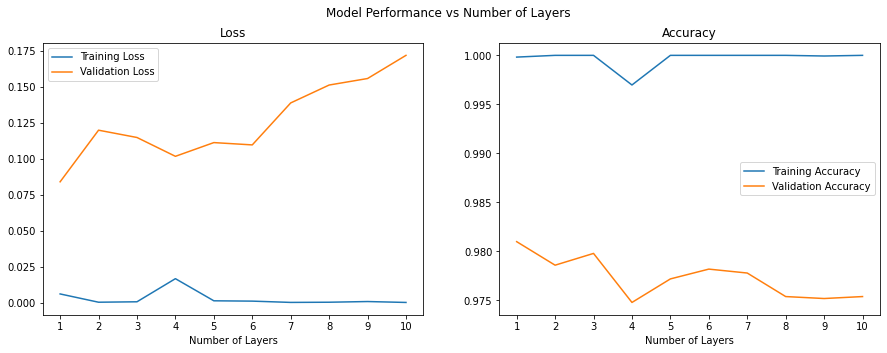

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Model Performance vs Number of Layers")
fig.set_size_inches(15, 5)

ax1.plot(results['train_loss'], label='Training Loss')
ax1.plot(results['val_loss'], label='Validation Loss')
ax1.set_xlabel('Number of Layers')
ax1.set_xticks(results.index)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(results['train_acc'], label='Training Accuracy')
ax2.plot(results['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Number of Layers')
ax2.set_xticks(results.index)
ax2.set_title('Accuracy')
ax2.legend()

fig.show()

In [ ]:
num_layers = 1

We have plotted the metrics for each number of layers. From the figure it is apparent that validation accuracy is maximum with number of hidden layers 1, 2 and 6 and the validation loss is minimum among these choices when number of hidden layers is 2. Hence we take 2 hidden layers in our model with number of units 432, 272 respectively.

# Picking Best Model

In [ ]:
model = models[num_layers - 1]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 400)               314000    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                4010      
Total params: 318,010
Trainable params: 318,010
Non-trainable params: 0
_________________________________________________________________


# Training History and Model Performace

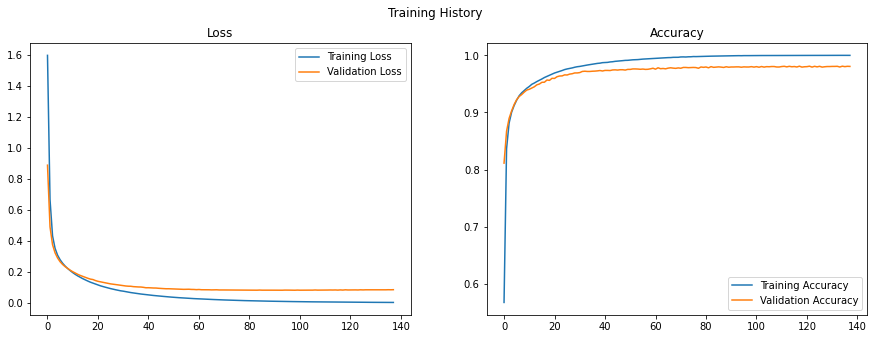

In [ ]:
plot_training_history(model.training_history)

In [ ]:
nn_train_loss, nn_train_acc = model.evaluate(Z_train, y_train, verbose=0)
nn_test_loss,  nn_test_acc  = model.evaluate(Z_test,  y_test,  verbose=0)

print(f"Training Accuracy: {nn_train_acc:2.2%}")
print(f"Test Accuracy:     {nn_test_acc :2.2%}")
print(f"Training Loss: {nn_train_loss:.6}")
print(f"Test Loss:     {nn_test_loss :.6}")

Training Accuracy: 99.98%
Test Accuracy:     97.91%
Training Loss: 0.00605645
Test Loss:     0.0700082


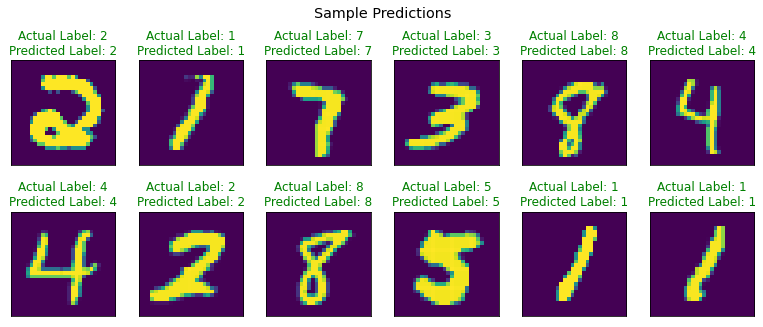

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
show_example(X_test, y_test, y_pred)

# Saving Trained Model

In [ ]:
model.save(f'{root}/models/nn_unrotated_model_wo_pca')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/MNIST-classification/models/nn_unrotated_model_wo_pca/assets


# Training Model with Dimension Reduction

The previous model was built with all the features taken into account. But there may be some features (in this case pixels) that varies less than some other features. Those features not only less useful in training the classifier but also works as noise that may hinder the model performance. To check if there actually is some feature like that we plot the standard daviation for each feature.

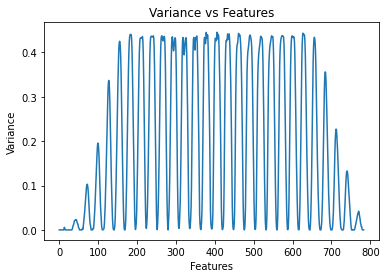

In [ ]:
plt.plot(np.std(X, axis=0))
plt.title('Variance vs Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.show()

It is apparent from the figure that some features (or pixels) have very small standard daviation compared to some others. A possible reason may be that the corner or edge pixels have less importance than the pixels in the middle to explain the subject. We apply PCA algorithm to filter out features so that 90% variablity is retained.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.90)
    # MinMaxScaler()
)
Z_train = pipe.fit_transform(X_train)
Z_test = pipe.transform(X_test)
Z_val = pipe.transform(X_val)

import pickle
with open(f'{root}/models/scaler_w_pca.pkl', 'wb') as f:
    pickle.dump(pipe, f)

_, n_features = Z_train.shape

print(f"No. of features:\t\t{n_features}")
print(f"No. of training examples:\t{train_size}")
print(f"No. of test examples:\t\t{test_size}")

No. of features:		232
No. of training examples:	50000
No. of test examples:		10000


As we can see the number of features is reduced from 784 to 232 with 90% variablity still retained.

# Selecting Model Architecture by Cross-validation (with Dimension Reduction)


## Searching for the Best Model 

In [ ]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    tuner.search(
        Z_train, y_train, validation_data=(Z_val, y_val),
        epochs=10000, batch_size=5000, verbose=1, callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.9485999941825867

Best val_accuracy So Far: 0.9670000076293945
Total elapsed time: 00h 02m 42s
INFO:tensorflow:Oracle triggered exit


## Creating Models from the Best Model Architecture

In [ ]:
models = []
for num_units in params.values():
    model = create_model(n_features, num_units)
    models.append(model)

In [ ]:
for model in models:
    print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 384)               89472     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                3850      
Total params: 93,322
Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 320)               74560     
_________________________________________________________________
dense_14 (Dense)             (None, 400)               128400    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                4010      
Total params: 206,970
T

## Training the Models

In [ ]:
metrics = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 
                                'val_loss', 'val_acc'])

for i, model in enumerate(models):

    print(f"Training Model {i+1}:")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    # training the model
    training_history = model.fit(
        Z_train, y_train, validation_data=(Z_val, y_val),
        epochs=500, batch_size=10000,
        shuffle=True, verbose=1, callbacks=[es]
    )
    # Storing the training history in the model
    model.training_history = training_history
    clear_output()

    # Get and store acurracies and losses
    train_loss, train_acc = model.evaluate(Z_train, y_train)
    valid_loss, valid_acc = model.evaluate(Z_val, y_val)
    clear_output()

    metrics = metrics.append(dict(
        n_layers=len(model.layers) - 1,
        train_loss=train_loss,
        train_acc=train_acc,
        val_loss=valid_loss,
        val_acc=valid_acc
    ), ignore_index=True)

The training and validation accuracies and losses are stored in `metrics` for each number of layers. We compare the metrices and pick the model with best validation accuracy.

In [ ]:
results = metrics.set_index('n_layers')
num_layers = results['val_acc'].idxmax().astype('int')
results

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.018525,0.998089,0.158348,0.9718
2.0,0.028242,0.995156,0.187668,0.9660
3.0,0.042120,0.990600,0.183195,0.9618
4.0,0.034606,0.992644,0.165001,0.9630
5.0,0.047707,0.988022,0.188727,0.9608
6.0,0.041023,0.990156,0.207617,0.9630
7.0,0.068423,0.981133,0.217912,0.9578
8.0,0.058421,0.984111,0.212455,0.9570
9.0,0.061292,0.982578,0.215464,0.9540


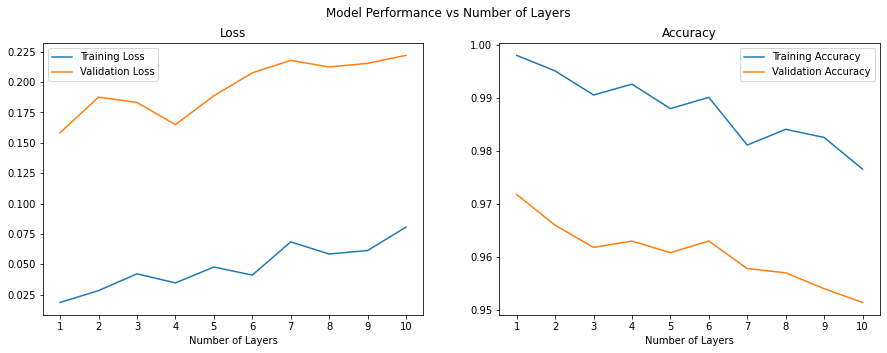

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Model Performance vs Number of Layers")
fig.set_size_inches(15, 5)

ax1.plot(results['train_loss'], label='Training Loss')
ax1.plot(results['val_loss'], label='Validation Loss')
ax1.set_xlabel('Number of Layers')
ax1.set_xticks(results.index)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(results['train_acc'], label='Training Accuracy')
ax2.plot(results['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Number of Layers')
ax2.set_xticks(results.index)
ax2.set_title('Accuracy')
ax2.legend()

fig.show()

We have plotted the metrics for each number of layers. From the figure it is apparent that validation accuracy is maximum with one hidden layer. The number of units for which validation accuracy is maximum is 368.

# Picking Best Model (with Dimension Reduction)


In [ ]:
model = models[num_layers - 1]
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 384)               89472     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                3850      
Total params: 93,322
Trainable params: 93,322
Non-trainable params: 0
_________________________________________________________________


# Training History and Model Performace (with Dimension Reduction)

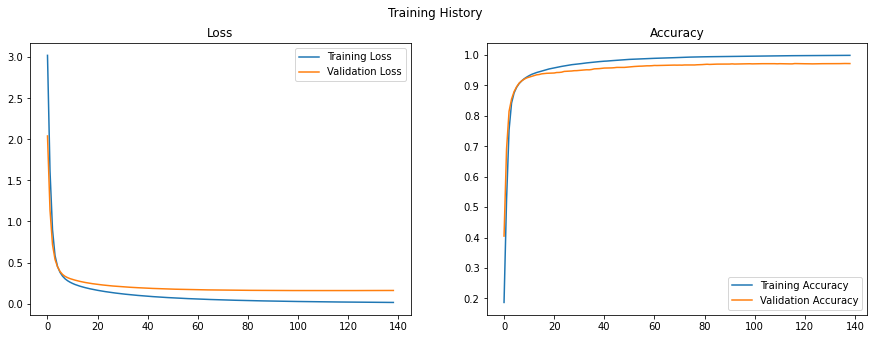

In [ ]:
plot_training_history(model.training_history)

In [ ]:
nn_train_loss, nn_train_acc = model.evaluate(Z_train, y_train, verbose=0)
nn_test_loss,  nn_test_acc  = model.evaluate(Z_test,  y_test,  verbose=0)

print(f"Training Accuracy: {nn_train_acc:2.2%}")
print(f"Test Accuracy:     {nn_test_acc :2.2%}")
print(f"Training Loss: {nn_train_loss:.6}")
print(f"Test Loss:     {nn_test_loss :.6}")

Training Accuracy: 99.81%
Test Accuracy:     96.98%
Training Loss: 0.018525
Test Loss:     0.130175


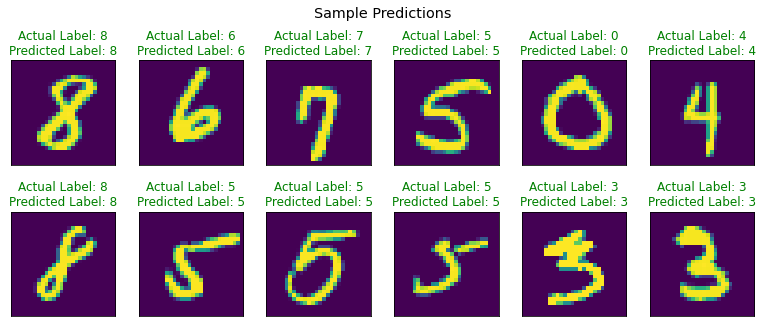

In [ ]:
y_pred = np.argmax(model.predict(Z_test), axis=-1)
show_example(X_test, y_test, y_pred)

# Saving Trained Model (with Dimension Reduction)

In [ ]:
model.save(f'{root}/models/nn_unrotated_model_w_pca')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/MNIST-classification/models/nn_unrotated_model_w_pca/assets


# Conclusion

|           |Training Accuracy|Test Accuracy|
|:---------:|:---------------:|:-----------:|
|Without PCA|      99.98%     |    97.91%   |
|With PCA   |      99.81%     |    96.98%   |

Clearly the accuracy decreased after applying PCA with 90% variability retained.